In [1]:
# Most Important 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# other
import missingno as msno
import joblib
import tarfile
import os
import urllib

### Scikit-learn

from sklearn import datasets
from sklearn import utils

# Metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# Preprocessing & Imputing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Validating and Tuning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Algorithms
import xgboost as xgb

from sklearn.linear_model import LinearRegression, SGDClassifier, SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

## Voting Classifiers

In [2]:
iris = datasets.load_iris()
df_iris = pd.DataFrame(np.c_[iris.data, iris.target], columns=iris.feature_names+['target'])

# shuffle the data
df_iris = utils.shuffle(df_iris)

X = df_iris.drop(columns=['target'], axis=1).astype(np.float64)
y = df_iris['target'].astype(np.float64)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, random_state=42, shuffle=True)

In [4]:
log_clf = LogisticRegression(max_iter=10000)
forest_clf = RandomForestClassifier()
svc_clf = SVC(probability=True, max_iter=10000)

In [5]:
vote_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                        ('forest', forest_clf), 
                                        ('svc', svc_clf)], 
                            voting='soft', n_jobs=-1)   ## tou can try both (hard and soft voting)

vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=10000)),
                             ('forest', RandomForestClassifier()),
                             ('svc', SVC(max_iter=10000, probability=True))],
                 n_jobs=-1, voting='soft')

In [6]:
classifiers = [log_clf, forest_clf, svc_clf, vote_clf]

for alg in classifiers:
    
    alg.fit(X_train, y_train)
    y_predict = alg.predict(X_val)
    
    print(alg.__class__.__name__, accuracy_score(y_val, y_predict))
    print('==='*10)

LogisticRegression 0.9333333333333333
RandomForestClassifier 0.9333333333333333
SVC 0.9
VotingClassifier 0.9


### Bagging and Pasing

**Bagging is an ensemble Method stands for (BOOSTSTRAP AGGREGATION)**  <br />
* Bagging is parallel method and with replacement in dataset <br />
* Bagging is parallel method and without replacement in dataset for the same predictor

* if you set (bootstrap=True => 'bagging' , bootstrap=False => 'pasting') 

####  BaggingClassifier for DT or you cam use RandomForest
* i will show both Methods

#### 1. Bagging

In [7]:
## Bagging

bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                            n_estimators=300, 
                            bootstrap=True, 
                            max_samples=1.0, n_jobs=-1, oob_score=True)  
# max_samples=1.0 >> size of each = size of whole data
## bootstrap and max_samples for instances
## bootstrap_features and max_features are for features
## you can make sampling subsets in both directions or both

bag_clf.fit(X_train, y_train)

## score of OOB (out of bag scores)
print('Out of bag scores =>', bag_clf.oob_score_)

## predcict and get the score
y_pred_bag = bag_clf.predict(X_val)

score_bagging = accuracy_score(y_val, y_pred_bag)
print('score_bagging_testing =>', score_bagging)  

### data is too small and it is very very simple (just for illustration)

Out of bag scores => 0.9583333333333334
score_bagging_testing => 0.9


In [8]:
### make grid search for both (bagging and pasting)


best_params = {'bootstrap': [False, True], 
               'n_estimators': np.arange(200,500,100)}


grid_search_bag_past = GridSearchCV(bag_clf, 
                                    param_grid=best_params, cv=5, 
                                    n_jobs=-1, scoring='accuracy')

grid_search_bag_past.fit(X_train, y_train)


## best model
best_bag_past = grid_search_bag_past.best_estimator_

print('score_bag_past =>', accuracy_score(y_val, best_bag_past.predict(X_val)))
### data is too small and it is very very simple (just for illustration)

C:\Users\moham\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.96666667 0.96666667 0.96666667]
  warnings.warn(


score_bag_past => 0.9


#### 1. RandomForest

In [9]:
#### forest

rnd_clf = RandomForestClassifier(n_estimators=300, max_depth=3, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

print('score_forest =>', accuracy_score(y_val, rnd_clf.predict(X_val)))
### data is too small and it is very very simple (just for illustration)


## get the same code of above RandomForest using BaggingClassifier

bag_forest = BaggingClassifier(DecisionTreeClassifier(max_depth=3, splitter='random'), 
                               n_estimators=300,
                               max_samples=1.0,  
                               bootstrap=True, n_jobs=-1)

## (max_samples=1.0) => should be float number (1.0 the same size of whole data)
bag_forest.fit(X_train, y_train)

print('bag_forest =>', accuracy_score(y_val, bag_forest.predict(X_val)))
### data is too small and it is very very simple (just for illustration)



score_forest => 0.9333333333333333
bag_forest => 0.9333333333333333


#### Feature impoertances

In [10]:
col_names = list(X_train.columns)

impotances = rnd_clf.feature_importances_

df_importances = pd.DataFrame({'Names': col_names, 'importances':impotances})
df_importances = df_importances.sort_values('importances', ascending=False).reset_index()

print(df_importances)

print('==='*20)
################### Another Method ####################

for name, score in zip(iris.feature_names, rnd_clf.feature_importances_):
    print(name, '=>', score)

   index              Names  importances
0      2  petal length (cm)     0.486378
1      3   petal width (cm)     0.416757
2      0  sepal length (cm)     0.083799
3      1   sepal width (cm)     0.013065
sepal length (cm) => 0.08379910887995216
sepal width (cm) => 0.01306507819867732
petal length (cm) => 0.48637833945828274
petal width (cm) => 0.41675747346308784


### Boosting

* Boosting is sequential method and with  <br />
* some techniques of Boosting are (AdaBoost, GradientBoosting)
     * AdaBoost tries to solve the missclassified instances sequentially by giving more weights to it and try to solve again and so on until estimating for all predictors
     
     * GradientBoosting tries to solve the residual errors of instances sequentially and the total prediction is the sum af all trials to solve this errors



### AdaBoost

* scikit-learn uses a multiclass version of Adaboost called SAMME so use Algorithm (SAMME.R)
* algorithm='SAMME.R' 
* learning_rate , which is used to get (predictor weights) , default=1.0


In [11]:
### AdaBoost Classifiers

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), 
                             n_estimators=300, algorithm='SAMME.R', 
                             learning_rate=0.5)

ada_clf.fit(X_train, y_train)

print('ada_clf =>', accuracy_score(y_val, ada_clf.predict(X_val)))
### data is too small and it is very very simple (just for illustration)

ada_clf => 0.9


### GradientBoosting

* GradientBoosting tries to solve the residual errors of instances sequentially and the total prediction is the sum af all trials to solve this errors

* learning_rate here is used to sacle the contribution of each tree

    * `if you think your Model is Overfitting , you can regularize the Model using learning_rate ` <br />
    * ` this technique of Regularization is called (Shrinkage)`

In [12]:
X = 6 * np.random.rand(100, 1) - 3
y = np.squeeze(0.5 * X**2 + X + 2 + np.random.rand(100, 1))

#### Manually

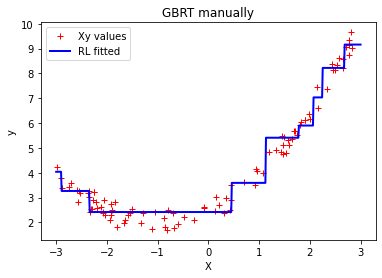

In [13]:
### try GradientBoosting Manually
## Using Decision Trees

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

##

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

### 
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)


#### final Prediction
X_new = np.linspace(-3,3,500).reshape(-1,1)
y_pred_manually = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

## Plotting
plt.plot(X, y, 'r+', label='Xy values')
plt.plot(X_new, y_pred_manually, linewidth=2, c='b', label='RL fitted')
plt.title('GBRT manually')
plt.xlabel('X')
plt.ylabel('y')
plt.legend();

#### Using GradientBoosting

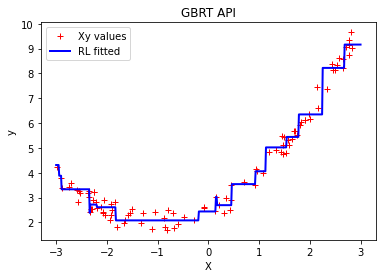

In [14]:
### (n_estimators=3) just for example as i did above
# if you think your Model is Overfitting , you can regularize the Model using learning_rate 
# this technique of Regularization is called (Shrinkage)

gbrt = GradientBoostingRegressor( n_estimators=3, 
                                 learning_rate=1, random_state=42,loss='ls') 
## ls refers to leat squares

gbrt.fit(X, y)

#### final Prediction
X_new = np.linspace(-3,3,500).reshape(-1,1)
y_pred_gbrt = gbrt.predict(X_new)

## Plotting
plt.plot(X, y, 'r+', label='Xy values')
plt.plot(X_new, y_pred_gbrt, linewidth=2, c='b', label='RL fitted')
plt.title('GBRT API')
plt.xlabel('X')
plt.ylabel('y')
plt.legend();

#### trade-off between (learning_rate & n_estimators)
` Reducing of learning_rate requires incresing n_estimators, it will need more trees to fit`<br />


` Low learning_rate >>> High n_estimators`  <br />
` High learning_rate >>> Low n_estimators`

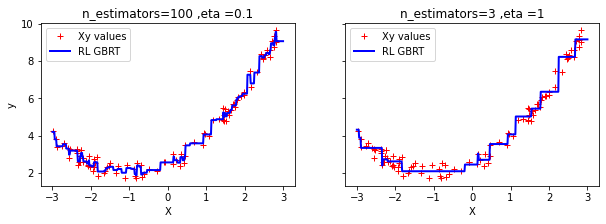

In [15]:
gbrt1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, criterion='mse')
gbrt2 = GradientBoostingRegressor(n_estimators=3, learning_rate=1, criterion='mse')

gbrt1.fit(X, y)
gbrt2.fit(X, y)

#### final Prediction
X_new = np.linspace(-3,3,500).reshape(-1,1)
y_pred_gbrt1 = gbrt1.predict(X_new)
y_pred_gbrt2 = gbrt2.predict(X_new)


### plotting

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10,3))

plt.sca(axes[0])
plt.plot(X, y, 'r+', label='Xy values')
plt.plot(X_new, y_pred_gbrt1, linewidth=2, c='b', label='RL GBRT')
plt.title(f'n_estimators={gbrt1.n_estimators_} ,eta ={gbrt1.learning_rate}')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

plt.sca(axes[1])
plt.plot(X, y, 'r+', label='Xy values')
plt.plot(X_new, y_pred_gbrt2, linewidth=2, c='b', label='RL GBRT')
plt.title(f'n_estimators={gbrt2.n_estimators_} ,eta ={gbrt2.learning_rate}')
plt.xlabel('X')
plt.legend()
plt.show()

#### early stopping method 

`using (staged_predcit) Method for early stopping`

errors shape = (n_estimators[1....150]) ===> 150
n_best_estimator => 33


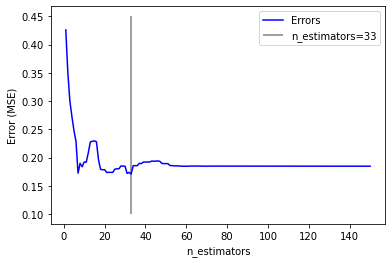

In [56]:
### split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42, shuffle=True)

### for each n_estimators it will iterate from 1 to 150 and each time get the model fitted
### and each time predict  get error and so on
### you can get the argmin where the minimum is minmized as possible as it is before it returns up
### get this index from n_estimators , then this n_estimators is the best 
### under other conditions of learning_rate and max_depth
gbrt_new = GradientBoostingRegressor(n_estimators=150, learning_rate=1.0, max_depth=2)
gbrt_new.fit(X_train, y_train)


errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt_new.staged_predict(X_val)]

print('errors shape = (n_estimators[1....150]) ===>', len(errors))

### get argmin

### increse one as n_estimators starts from 1 
### and argmin starts from 0
n_best_estimator = np.argmin(errors) + 1 
print('n_best_estimator =>', n_best_estimator)



### some plottings

estimators = np.arange(1, 151)
plt.plot(estimators, errors, 'b', label='Errors')

plt.vlines(x=33, ymin=0.1, ymax=0.45, colors='gray', label='n_estimators=33')

plt.xlabel('n_estimators')
plt.ylabel('Error (MSE)')
plt.legend()
plt.show()


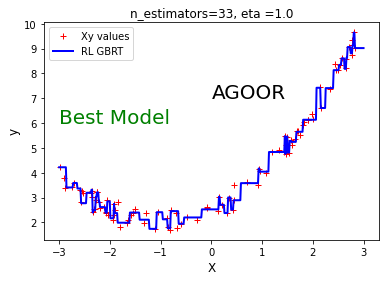

In [60]:
### modify the n_estimators to be 11

gbrt_final = GradientBoostingRegressor(n_estimators=33, learning_rate=1.0, max_depth=2)
gbrt_final.fit(X_train, y_train)

#### final Prediction
X_new = np.linspace(-3, 3, 500).reshape(-1,1)
y_pred_final = gbrt_final.predict(X_new)

plt.plot(X, y, 'r+', label='Xy values')
plt.plot(X_new, y_pred_final, linewidth=2, c='b', label='RL GBRT')
plt.text(-3, 6, 'Best Model', fontsize=20, c='g')
plt.text(0, 7, 'AGOOR', fontsize=20, c='k')
plt.title(f'n_estimators={gbrt_final.n_estimators_}, eta ={gbrt_final.learning_rate}')
plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend()
plt.show()

## XGBoost 
`Extreme Gradient Boosting`  <br />
`XgBoost is very powerfull API and also offers several nice features such as (early stopping)`

In [22]:
xgb_reg = xgb.XGBRegressor()

In [26]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
rmse_logError = (mean_squared_log_error(y_val, xgb_reg.predict(X_val)))**0.5

print('rmse_logError =>', rmse_logError)

rmse_logError => 0.1129976878550634
